In [2]:
# Importing all the required libraries
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
import os, os.path
from torch.optim import lr_scheduler 
import time
import copy
from tqdm import tqdm
import os

In [3]:
#Initiating the transformations to the image
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(45),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       ])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      ])
pred_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      ])


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Loading the dataset from a folder
data_path = "/content/drive/MyDrive/Datasets/Christmas_challenge/train"


data = datasets.ImageFolder(data_path,transform=train_transforms)
print("Number of classes=",len(data.classes))
classes = data.classes
print(classes)

Number of classes= 8
['christmas_cookies', 'christmas_presents', 'christmas_tree', 'fireworks', 'penguin', 'reindeer', 'santa', 'snowman']


In [6]:
#splitting the dataset to training and validation data.
train_data, val_data = torch.utils.data.random_split(data, [3500, 226])
print(len(train_data))
print(len(val_data))

#Creating data loader's for trainig and validation data.
batch_size = 5
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True) 


3500
226


In [7]:
#loading the test images to be predicted.
test_imgs = []
path = "/content/drive/MyDrive/Datasets/Christmas_challenge/val"
valid_images = ".png"
print(len(os.listdir(path)))

for i in os.listdir(path):
    ext = os.path.splitext(i)[1]
    if ext.lower() != valid_images:
        continue
    test_imgs.append(Image.open(os.path.join(path,i)))


test_transformed_imgs =[]

# Applying the transformations to the test images
for i in test_imgs:
  i = pred_transforms(i)
  test_transformed_imgs.append(i)

batch_size = 5
#Creating the data Loader for Test images.
pred_loader = torch.utils.data.DataLoader(test_transformed_imgs , batch_size=batch_size,shuffle=True) 

160


In [8]:
#Setting up the device to use GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [9]:
#Importing the pre-trained VGG16 model
import torchvision.models as models

vgg_model = models.vgg16(pretrained=True)
print(vgg_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
num_features = vgg_model.classifier[6].in_features
print(num_features)

vgg_model.classifier[6].out_features = 8

# Freeze convolution weights
for param in vgg_model.features.parameters():
    param.requires_grad = False

# Sending the model to the device (CPU/GPU)
vgg_model.to(device)

4096


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

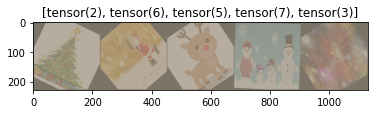

In [11]:
#unnormalizing the images and plotting the batch of images. 
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Getting a batch of training data
inputs, category = next(iter(train_loader))

# Plotting the batch of images using the Grid.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes[category])

In [22]:
#setting up the loss function and the optimizer.
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg_model.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
train_loss_epoch = []
train_accu_epoch = []
val_loss_epoch = []
val_accu_epoch = []

In [23]:
# Defining the function for training the model.
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        # Setting up training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
               model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over batch of data.
            for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # Calculating gradient only in training phase.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() 
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = (running_loss) / (batch_size*len(train_loader))
            epoch_acc = (running_corrects.double()) / (batch_size*len(train_loader))
            if phase == 'train':
              print("::::::::::::::::::::::::::::::::::::::::",epoch_loss)
              train_loss_epoch.append(epoch_loss)
              train_accu_epoch.append(epoch_acc)
              print('to check:::::::::::::::::::::::::::::::::::::::::::::::;',train_loss_epoch)
            else:
              print("::::::::::::::::::::::::::::::::::::::::",epoch_loss)
              val_loss_epoch.append(epoch_loss)
              val_accu_epoch.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print("Training loss at the end of the training",epoch_loss)
    print("Training accuracy at the end of the training",epoch_acc)
    return vgg_model

In [ ]:
epochs = 3
vgg_classifier =  train_model(vgg_model, criterion, optimizer, exp_lr_scheduler , num_epochs=epochs)

Epoch 1/3
----------


100%|██████████| 700/700 [02:09<00:00,  5.38it/s]


:::::::::::::::::::::::::::::::::::::::: 0.15363863098788508
to check:::::::::::::::::::::::::::::::::::::::::::::::; [0.15363863098788508]
train Loss: 0.1536 Acc: 0.7466


100%|██████████| 700/700 [01:44<00:00,  6.72it/s]


:::::::::::::::::::::::::::::::::::::::: 0.11536694171487553
val Loss: 0.1154 Acc: 0.7980
Epoch 2/3
----------


 55%|█████▌    | 386/700 [01:11<00:58,  5.38it/s]

In [18]:
print( train_loss_epoch)

NameError: ignored

In [19]:
#Saving the trained model.
torch.save(vgg_classifier , 'model' + '.pt')

In [20]:
#Loading the trained model.
model = torch.load('model.pt')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
#Plotting the training and validtion losses.
epochs = [*range(1,epochs+1,1)]

plt.plot(epochs, train_loss_epoch, 'g', label='Training loss')
plt.plot(epochs, val_loss_epoch, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



NameError: ignored

In [ ]:
#Plotting the training and validtion Accuracy.
epochs = [*range(1,epochs+1,1)]
plt.plot(epochs, train_accu_epoch, 'g', label='Training Accuracy')
plt.plot(epochs, val_accu_epoch, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
#epochs = [i for i in range(15)]
[*range(1,5+1,1)]

In [ ]:
dataiter = iter(pred_loader)
images= dataiter.next()

imshow(torchvision.utils.make_grid(images))

images = images.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted classes : ', ' '.join('%s' %  classes[predicted[j]]
                              for j in range(len(images))))